In [1]:
import configparser
import os.path
from alpenglow.image_sources.s3 import S3ImageSource

path_format = 'prostate_draq5_eosin/draq5/im_{stripe_id:06d}_{version_id:06d}.tif'
stripe_ids = [0, 1, 2, 3, 4, 5, 6]
version_ids = list(range(1, 501))

config_parser = configparser.ConfigParser()
config_parser.read_file(open(os.path.join(os.path.expanduser('~'), '.aws', 'credentials')))
config_parser.sections()

aws_access_key_id = config_parser.get('default', 'AWS_ACCESS_KEY_ID')
aws_secret_access_key = config_parser.get('default', 'AWS_SECRET_ACCESS_KEY')

array_mapping = lambda a: a

image_source = S3ImageSource(path_format, stripe_ids, version_ids, aws_access_key_id, aws_secret_access_key, 'alpenglowoptics', 'https://s3.amazonaws.com', array_mapping=array_mapping)
print("configuration read")

configuration read


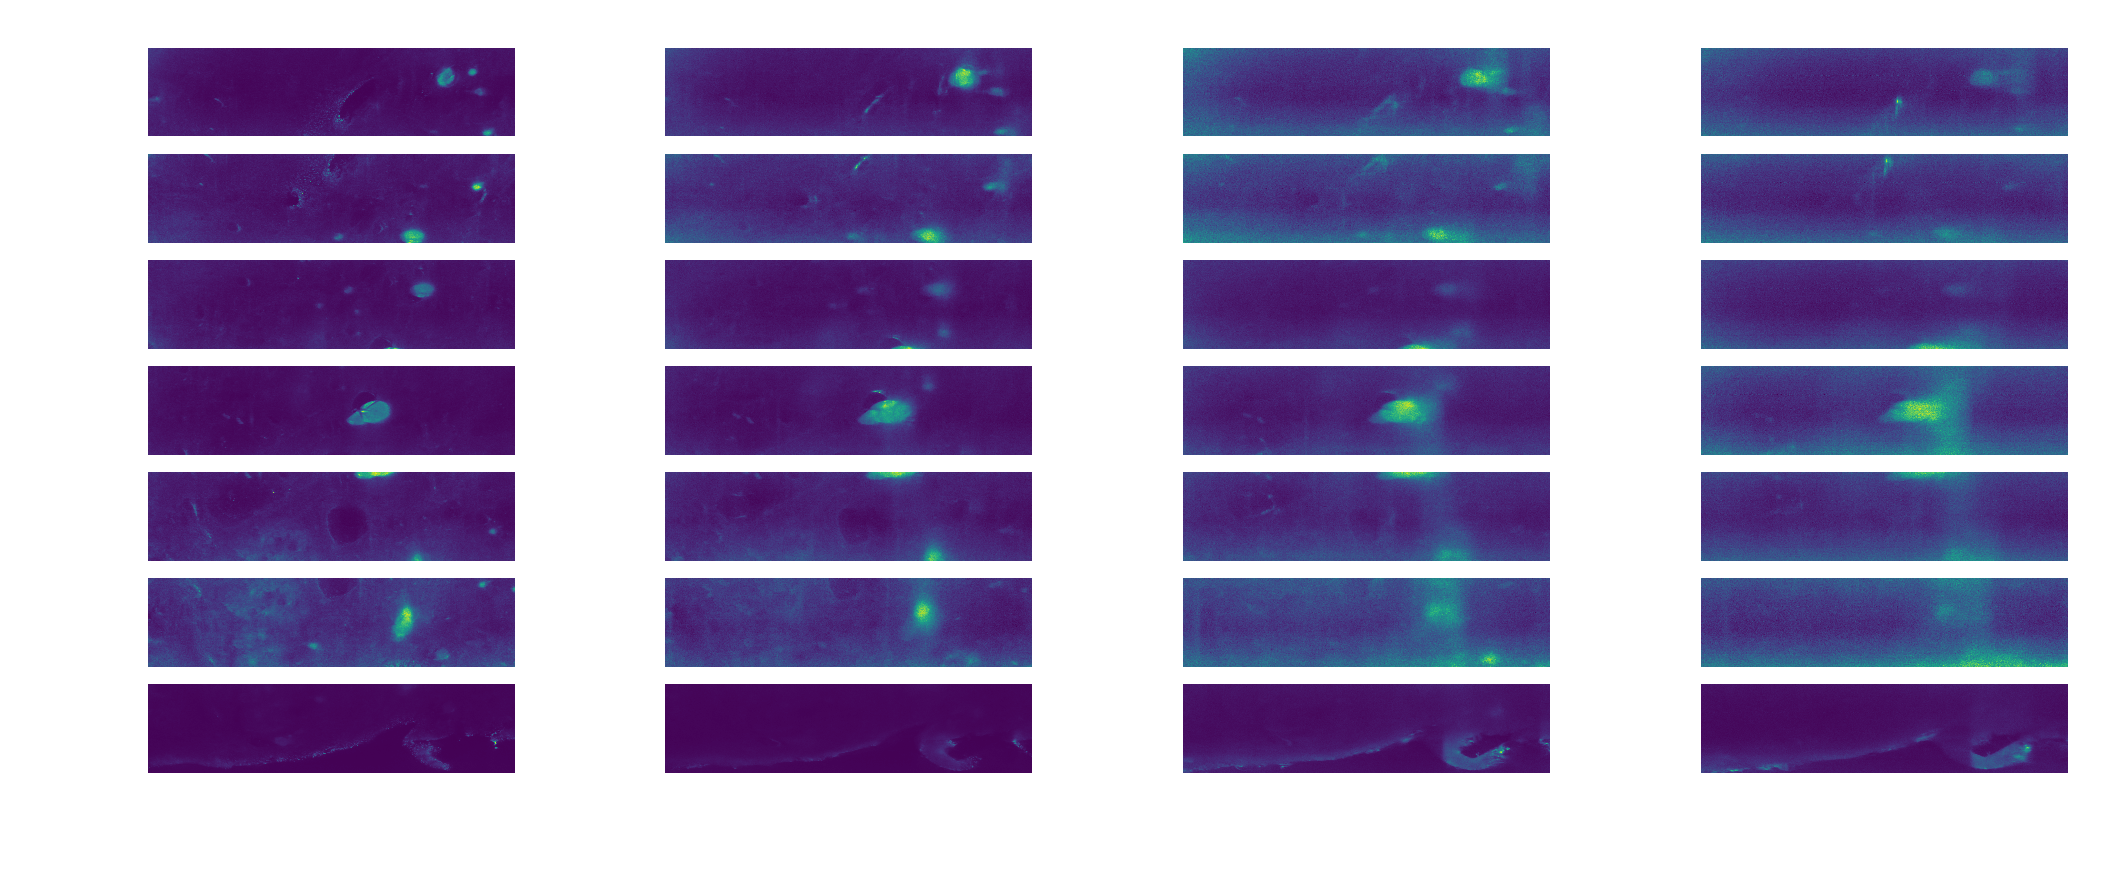

Average sample fetch time: 1.456343608243125
estimated required time 5097.202628850937


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent

from time import time
start_time=time()

demo_versions = [100, 200, 300, 400]
demo_stripes = [0, 1, 2, 3, 4, 5, 6]

fig = plt.figure(figsize=(8, 3), dpi=320)
future_to_position = {}
for version_index, version_id in enumerate(demo_versions, 1):
    for stripe_index, stripe_id in enumerate(demo_stripes, 0):
        future_to_position[image_source.get_image_future(stripe_id, version_id - 1)] = version_index + len(demo_versions) * stripe_index
        
for future in concurrent.futures.as_completed(future_to_position):
    ax = fig.add_subplot(len(demo_stripes), len(demo_versions), future_to_position[future])
    ax.imshow(future.result())
    ax.set_axis_off()
plt.show()

avg_image_fetch_time = (time() - start_time)/(len(demo_versions) * len(demo_stripes))
print("Average sample fetch time: {0}\nestimated required time {1}".format(avg_image_fetch_time, avg_image_fetch_time * len(demo_stripes) * len(version_ids)))

In [5]:
from alpenglow.matching_algorithms.fft import FftMatchingAlgorithm
matching_algorithm = FftMatchingAlgorithm(list(range(50, 499, 80)), [0])

In [6]:
from alpenglow.patchwork_builders.lazy import LazyPatchworkBuilder
from alpenglow.image_sources.benchmarking import BenchmarkingImageSource

benchmarking_image_source = BenchmarkingImageSource(image_source)
from time import time
start_time=time()

builder = LazyPatchworkBuilder(matching_algorithm)
for stripe_id in range(len(stripe_ids)):
    builder.stitch(benchmarking_image_source.get_stripe(stripe_id))

patchwork = builder.get()

print("total time: {0}s".format(time() - start_time))
stitching_times = builder.benchmark()
print("stitching times: {0}".format(stitching_times))
print("image fetching time: {0}".format(benchmarking_image_source.total_fetching_time()))

total time: 161.87796306610107s
stitching times: [2.1457672119140625e-06, 37.92775297164917, 26.95943808555603, 22.51028275489807, 26.237518072128296, 23.600008964538574, 24.621093034744263]
image fetching time: 813.8514964580536


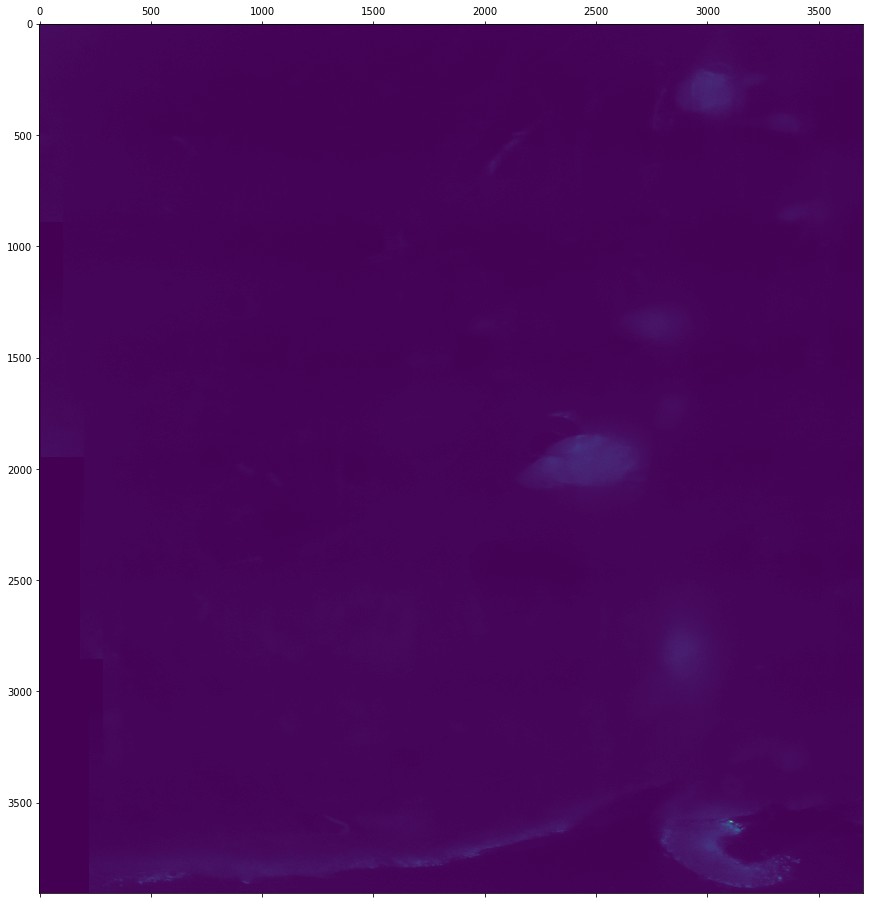

In [9]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.matshow(patchwork[200, :, :])
plt.show()